# Import modules and functions

In [1]:
# Import relevant modules and functions for scraping
# Basics
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set() 
sns.set_style("darkgrid")
# Diable warnings
import warnings
warnings.filterwarnings('ignore')
# Scraping
import re
import requests
# html parsing
from bs4 import BeautifulSoup
# Processing of parsed text
import os
import time
from collections import Counter
from IPython.display import clear_output

In [2]:
# Import relevant modules and functions for preprocessing & classification
# Data splitting
from sklearn.model_selection import train_test_split
# NLP preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
# Sampling methods
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Pipelines
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
# Roc-curve (AUC)
from sklearn.metrics import plot_roc_curve, roc_curve, auc
from sklearn.metrics import RocCurveDisplay #(new, previous one deprecated)
# Cross-validation
from sklearn.model_selection import cross_val_score
# Confusin matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# Different scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_squared_log_error, make_scorer, r2_score
# Hyperparameteroptimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
#import nltk
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download()

In [31]:
# Import modules and functions for wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# Define relevant functions

## Functions to scrape lyrics from www.lyrics.com

In [44]:
def get_main_url(artist):
    
    if url_dct.get(artist, 0) == 0:
        print(f"Main url for {artist.replace('_', ' ').capitalize()} will be retrieved and stored in internal database.")
        
        url_base = f'https://www.lyrics.com/'

        # Determine url for search results for artist
        url_search = url_base + 'lyrics/'
        for i, element in enumerate(artist.split('_')):
            if i == 0:
                url_search += element.lower().capitalize()
            else:
                url_search += f'%20{element.lower().capitalize()}'

        # Get url for artist from search results page
        response = requests.get(url_search, headers)
        artist_tf = '-'.join(item.lower().capitalize() for item in artist.split('_'))
        pattern = f'href="(artist\/{artist_tf}.*?)"'
        link = re.findall(pattern, response.text, re.IGNORECASE)
        url_albums = url_base + link[0]

        # Get url where songs are listed alphabetically
        response = requests.get(url_albums, headers)
        pattern = 'class="sort".+?href="(artist.+?)"'
        link = re.findall(pattern, response.text, re.IGNORECASE)
        url_song = url_base + link[0]

        url_dct[artist] = url_song
    else:
        print(f"Url for {artist.replace('_', ' ').capitalize()} already available in database.")

In [5]:
def clean_str(x):
    return x.strip().lower().replace("'", "").replace("’", "").replace("‘", "").replace(",", "").replace(".", "").replace(" ", "_")

In [6]:
def scrape_links(artist):
    
    url = url_dct[artist]
    
    if not os.path.exists(f'{artist}'):
        os.makedirs(f'{artist}')
        print(f'Created /{artist} folder.')
    
    if not os.path.isfile(f'{artist}/{artist}_main.txt'):
        response = requests.get(url, headers)
        file = open(f'{artist}/{artist}_main.txt', 'w')
        file.write(response.text)
        file.close()
        print(f'Downloaded and saved main_html in /{artist}.')
    
    file = open(f'{artist}/{artist}_main.txt', mode='r')
    main_content = file.read()
    file.close()
    
    pattern = '<a href="(\/lyric\S+?)">(?:\(.*?\))?(.+?)[-\/(\[<].+?<br>(\d{4})?'
    lyrics_and_titles = re.findall(pattern, main_content, re.IGNORECASE)
    
    url_base = 'https://www.lyrics.com'
    
    list_of_links = []
    list_of_titles = []
    list_of_years = []
    
    for item in lyrics_and_titles:
        list_of_links.append(url_base + item[0])
        list_of_titles.append(clean_str(item[1]))
        try:
            list_of_years.append(item[2])
        except:
            list_of_years.append(np.nan)
    
    df = pd.DataFrame({'title' : list_of_titles,  
                       'year' : list_of_years,
                       'link' : list_of_links})
    
    df.drop_duplicates(subset ="title", keep = 'first', inplace = True)
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df.drop(['index'], axis=1, inplace=True)
    
    df.to_excel(f'{artist}/df_{artist}.xlsx')
    print(f'Created df ({df.shape[0]} songs) with title, year and link in /{artist}.')

In [7]:
def scrape_lyrics(artist):   
    try:
        df = pd.read_excel(f'{artist}/df_{artist}.xlsx', index_col=0)
    except:
        print('Could not read df with titles and links.')
        return None
    
    if not os.path.exists(f'{artist}/lyrics'):
        os.makedirs(f'{artist}/lyrics')
        print(f'Created /{artist}/lyrics folder.')
   
    for idx, title, year, link in df.itertuples():
        if not os.path.isfile(f"{artist}/lyrics/{title}.txt"):
            time.sleep(np.random.randint(10) / 20) 
            response = requests.get(url=link, headers=headers)
            try:
                # Convert into 'soup' using BeautifulSoup
                lyrics_soup = BeautifulSoup(response.text, 'html')
                # Retrieve text from lyrics_soup
                lyrics_text = lyrics_soup.find(name='pre', class_='lyric-body').text
                # Safe lyrics in file
                open(file=f"{artist}/lyrics/{title}.txt", mode='w').write(lyrics_text)
            except:
                print(f'Could not retrieve and save lyrics for {title}')  
        else:
            print(f'File {title}.txt already exists.')
        
        clear_output(wait=True)
        print(f'{idx+1} of {df.shape[0]} song lyrics saved in /{artist}/lyrics.')
    
    clear_output(wait=True)
    print(f'Downloaded {df.shape[0]} song lyrics in /{artist}/lyrics.')

In [46]:
def join_all_data(artist):
    
    df_prv = pd.read_excel(f'{artist}/df_{artist}.xlsx', index_col=0)
    
    l_lyr = []
    for fn in os.listdir(f'{artist}/lyrics'):
        try:
            lyrics = open(f'{artist}/lyrics/' + fn, mode='r').read()
            l_lyr.append([fn[:-4], lyrics])    
        except:
            l_lyr.append([fn[:-4], np.nan])
            print(f'Could not add {fn}')
    
    df_lyr = pd.DataFrame(l_lyr, columns=['title', 'lyrics'])
    df = df_prv.set_index('title').join(df_lyr.set_index('title'))
    df.reset_index(inplace=True)
    
    df.dropna(inplace=True)
    df.drop_duplicates(subset='lyrics', keep='first', inplace=True)
    df.to_excel(f'{artist}/df_{artist}.xlsx')
    
    print(f"{df.shape[0]} unique songs identified for {artist.replace('_', ' ').capitalize()}")

## Functions to further process scraped data

In [40]:
def get_corpus_target(*artists):
    if artists:
        corpus = []
        target = []

        for artist in artists:
            try:
                df = pd.read_excel(f'{artist}/df_{artist}.xlsx', index_col=0)
                #print(f'{df.shape[0]} unique songs identified and added for {artist}.')

                for idx, lyrics, year in df[['lyrics', 'year']].itertuples():
                    try:
                        corpus.append(lyrics)
                        target.append([artist, year])
                    except:
                        continue
            except:
                print(f'Df /{artist}/df_{artist}.xlsx with lyrics does not exist') 

        #print(f'{len(corpus)} unique songs identified and added in total')
        return corpus, target
    else:
        print('Artist required.')

In [10]:
# Create customized tokenizer to extract words (including filtering and lemmatizing)
class CustomizedTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        l = [] 
        # Tokenize doc and filter out unwanted elements
        for t in word_tokenize(doc):
            is_token = []
            # filter out numbers 
            is_token.append(not re.search('\d+', t))
            # filter out punctuation
            is_token.append(not re.search('[^\w\s]', t))
            #filter out words <= 2 letters
            is_token.append(not re.search(r'(\b\w{1,2}\b)', t))
            # lematize tokens and append l
            if all(is_token): 
                l.append(self.wnl.lemmatize(t))
        # Return list of tokens
        return l

In [11]:
# Define pipeline for preprocessing (equivalent with using TfidfVectorizer)
preprocessor = Pipeline(steps=[
    ('cv', CountVectorizer(strip_accents='unicode', max_df=0.7,
                                      tokenizer=CustomizedTokenizer())),
    ('tf', TfidfTransformer())   
])

## Functions to create wordcloud

In [12]:
# Required to define white pixels in mask as '255' (assumes currently = 0, to be changed accordingly)
def transform_val(val):
    if val == 0:
        return 255
    else: 
        return val

In [13]:
# Builds mask for word-cloud based on png-file
def transform_png(file):
    mask = np.array(Image.open(file))
    mask_rs = mask.reshape(-1,1)
    mask_rs_tf = np.array([transform_val(val) for val in mask_rs], np.uint8)
    mask_tf = mask_rs_tf.reshape(mask.shape)
    return mask_tf

In [36]:
def get_words_for_cloud(artist):
    
    print('Collecting words for wordcloud - please wait...')
    data, y = get_corpus_target(artist)

    ct = CustomizedTokenizer()
    text = ''
    for lyrics in data:
        list_of_words = ct(lyrics)
        joined_words = ' '.join(word for word in list_of_words)
        text = text + ' ' + joined_words
    
    return text

In [57]:
# Function to create wordcloud (optimized for use of masks)
def create_wordcloud(artist, txt, msk=None, font_color='black'):
    
    cloud = WordCloud(background_color="white",
                    max_words=200,
                    min_font_size=1,
                    width=400, height=400,
                    mask=msk,
                    contour_width=0, contour_color='black',
                    collocations=False,  # calculates frequencies
                     ).generate(txt)
                    # stop words are removed!
    
    plt.figure(figsize = (12,12))
    #image_colors = ImageColorGenerator(msk)
    #plt.imshow(cloud.recolor(color_func=image_colors), interpolation='bilinear')
    plt.imshow(cloud.recolor(color_func=lambda *args, **kwargs: font_color), interpolation='bilinear')
    plt.axis("off")
    plt.savefig(f'{artist}_wrdcld.png')
    plt.show()

# Main programm

Downloaded 134 song lyrics in /ed_sheeran/lyrics.
133 unique songs identified for Ed sheeran


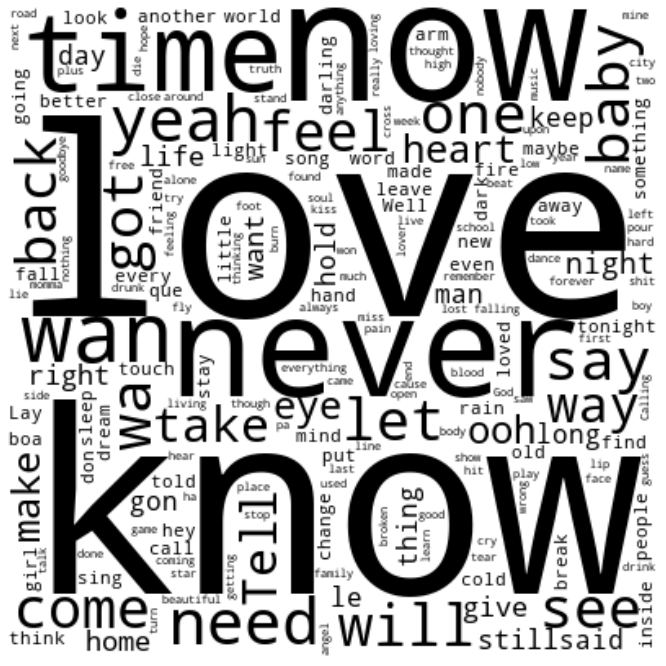

In [60]:
artist = input("Let's create a wordcloud - what is your favorite artist?\n")
mask_file = input("Do you want to define a mask for your wordcloud - if so, please insert file location.\n")
color = input("What is your favorite color - to give it a personal touch ;-)\n")

#artist = 'michael_jackson'
#mask_file = '../data/pngs_wrdcld/michael_jackson_1.png'

artist = artist.lower().replace(' ', '_')

url_dct = {}
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.4 Safari/605.1.15'} 

get_main_url(artist)
scrape_links(artist)
scrape_lyrics(artist)
join_all_data(artist)

text = get_words_for_cloud(artist)

try:
    mask = transform_png(mask_file)
except:
    mask = None

create_wordcloud(artist, text, mask, color)
